In [1]:
import warnings

def no_warning(*args, **kwargs):
    pass

warnings.warn = no_warning  # 모든 경고 무력화

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from IPython.display import display
from pprint import pprint
import os
import sys

# brainbox / iblatlas / ONE 관련
from brainbox.io.one import SessionLoader, SpikeSortingLoader
from brainbox.singlecell import bin_spikes
from iblatlas.atlas import AllenAtlas
from one.api import ONE





BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
print(f"BASE_DIR: {BASE_DIR}")

RESULT_DIR = os.path.join(BASE_DIR, 'result', 'VISp', 'lateralization')

def add_module_paths(base, *rel_paths):
    for rel_path in rel_paths:
        sys.path.append(os.path.join(base, *rel_path))

add_module_paths(BASE_DIR,
    ['func'],               # func 바로 아래 함수들
    ['func', 'compute'],
    ['func', 'info'],
    ['func', 'plot']
)

from print_cluster_info import print_cluster_info
from get_trial_masks import get_trial_masks
from compute_raster import compute_raster
from plot_raster import plot_raster
from plot_psth_2x2 import plot_psth_2x2
from plot_psth_contrast import plot_psth_contrast
from plot_psth_1 import plot_psth_left_vs_right
from sub_func import save_file


BASE_DIR: c:\Users\miasc\SCH\shinlab\IBL\VISp_PSTH


In [3]:
# -----------------------------------------------------------------------------
# 1. ONE 초기화 및 세션 검색(유연한 brain_acronym)
# -----------------------------------------------------------------------------
# 원하는 뇌영역 문자열을 지정(예: 'VISp', 'MOs' 등)

one = ONE()

session_dict = {}

for brain_acronym in ['VISp', 'VISl', 'VISal', 'VISam', 'VISpm', 'VISrl']:
    sessions = one.search(atlas_acronym=brain_acronym, query_type='remote') # probe 기준으로 search 됨
    session_dict[brain_acronym] = list(set(sessions)) # 중복 제거
    print(f"\n[{brain_acronym}] Detected sessions: {len(set(sessions))}") 

# 겹치는 세션들만 찾기
sessions_VISp_VISl = set(session_dict['VISp']).intersection(set(session_dict['VISl']))
print(f"\n🔍 {len(sessions_VISp_VISl)} sessions found in both VISp and VISl regions.")
sessions_VISp_VISpm = set(session_dict['VISp']).intersection(set(session_dict['VISpm']))
print(f"\n🔍 {len(sessions_VISp_VISpm)} sessions found in both VISp and VISpm regions.")
sessions_VISal_VISp_VISrl = set(session_dict['VISal']).intersection(set(session_dict['VISp'])).intersection(set(session_dict['VISrl']))
print(f"\n🔍 {len(sessions_VISal_VISp_VISrl)} sessions found in VISal, VISp, and VISrl regions.")



[VISp] Detected sessions: 68

[VISl] Detected sessions: 13

[VISal] Detected sessions: 5

[VISam] Detected sessions: 34

[VISpm] Detected sessions: 28

[VISrl] Detected sessions: 9

🔍 5 sessions found in both VISp and VISl regions.

🔍 15 sessions found in both VISp and VISpm regions.

🔍 1 sessions found in VISal, VISp, and VISrl regions.


<Figure size 1200x600 with 0 Axes>

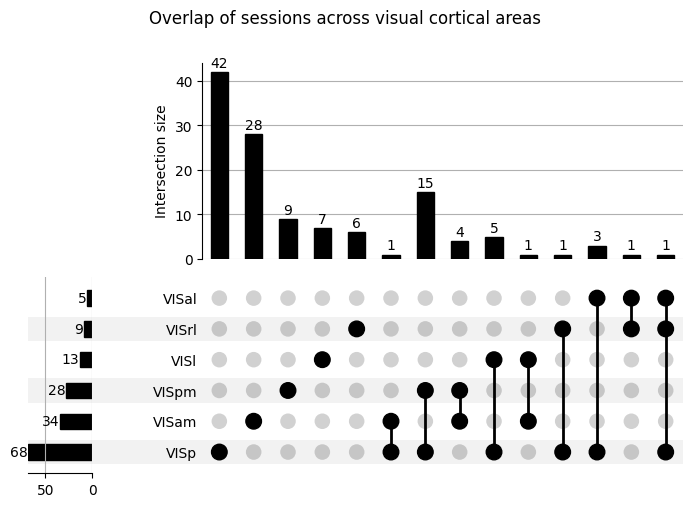

In [4]:
from upsetplot import UpSet, from_memberships
import matplotlib.pyplot as plt

# 각 세션이 어떤 영역에 포함되는지 추적
from collections import defaultdict

session_to_areas = defaultdict(set)
for area, session_ids in session_dict.items():
    for sid in list(session_ids):  # Lazy 객체라면 list 변환
        session_to_areas[sid].add(area)

# 세션별 포함 관계 → UpSet용 데이터로 변환
memberships = [tuple(sorted(areas)) for areas in session_to_areas.values()]
data = from_memberships(memberships)

# 시각화
plt.figure(figsize=(12, 6))
UpSet(data, subset_size='count', show_counts=True).plot()
plt.suptitle("Overlap of sessions across visual cortical areas")
plt.show()


In [5]:
# session_dict 내 session들을 모두 합쳐서, 중복 값이 존재하는지 여부 확인

from collections import defaultdict, Counter

# (1) 세션 ID를 영역별로 추적
session_to_regions = defaultdict(set)

for region, session_list in session_dict.items():
    for session in list(session_list):  # <- Lazy 객체를 명시적으로 리스트로 변환
        session_to_regions[session].add(region)

# (2) 등장 횟수 세기
session_counts = Counter()

for sessions in session_dict.values():
    session_counts.update(list(sessions))  # <- 여기도 변환 필요

# (3) 중복 세션 + 해당 영역 출력
duplicate_sessions = {sess for sess, count in session_counts.items() if count > 1}

if duplicate_sessions:
    print(f"🔁 중복된 세션이 {len(duplicate_sessions)}개 있습니다:\n")
    for sess in sorted(duplicate_sessions):
        regions = sorted(session_to_regions[sess])
        print(f"- 세션 {sess} ➜ 영역들: {', '.join(regions)}")
else:
    print("✅ 중복된 세션은 없습니다.")

🔁 중복된 세션이 32개 있습니다:

- 세션 07dc4b76-5b93-4a03-82a0-b3d9cc73f412 ➜ 영역들: VISp, VISpm
- 세션 09156021-9a1d-4e1d-ae59-48cbde3c5d42 ➜ 영역들: VISal, VISrl
- 세션 111c1762-7908-47e0-9f40-2f2ee55b6505 ➜ 영역들: VISam, VISp
- 세션 239dd3c9-35f3-4462-95ee-91b822a22e6b ➜ 영역들: VISam, VISpm
- 세션 35ed605c-1a1a-47b1-86ff-2b56144f55af ➜ 영역들: VISl, VISp
- 세션 57fd2325-67f4-4d45-9907-29e77d3043d7 ➜ 영역들: VISp, VISpm
- 세션 5ae68c54-2897-4d3a-8120-426150704385 ➜ 영역들: VISp, VISpm
- 세션 5c0c560e-9e1f-45e9-b66e-e4ee7855be84 ➜ 영역들: VISp, VISpm
- 세션 6274dda8-3a59-4aa1-95f8-a8a549c46a26 ➜ 영역들: VISp, VISpm
- 세션 7b26ce84-07f9-43d1-957f-bc72aeb730a3 ➜ 영역들: VISp, VISpm
- 세션 7cb81727-2097-4b52-b480-c89867b5b34c ➜ 영역들: VISp, VISpm
- 세션 7cc74598-9c1b-436b-84fa-0bf89f31adf6 ➜ 영역들: VISal, VISp
- 세션 83e77b4b-dfa0-4af9-968b-7ea0c7a0c7e4 ➜ 영역들: VISp, VISrl
- 세션 85dc2ebd-8aaf-46b0-9284-a197aee8b16f ➜ 영역들: VISp, VISpm
- 세션 872ce8ff-9fb3-485c-be00-bc5479e0095b ➜ 영역들: VISl, VISp
- 세션 8a1cf4ef-06e3-4c72-9bc7-e1baa189841b ➜ 영역들: VISal, VISp, VI

In [6]:
# eid = 'ca4ecb4c-4b60-4723-9b9e-2c54a6290a53' # VISp
# eid = 'aa3432cd-62bd-40bc-bc1c-a12d53bcbdcf' # VISp, VISpm
# eid = '07dc4b76-5b93-4a03-82a0-b3d9cc73f412' # VISp, VISpm
eid = '8a1cf4ef-06e3-4c72-9bc7-e1baa189841b' # VISp, VISal, VISrl
pids, probe_labels = one.eid2pid(eid)  # pids는 list, probe_labels는 dict
print(f"\n🔍 Detected pids for eid {eid}: {len(pids)}")

# pids와 probe_labels 출력
for i, (pid, probe_label) in enumerate(zip(pids, probe_labels)):
    print(f"🔍 pid[{i}]: {pid}, label: {probe_label}")

for i, (pid, probe_label) in enumerate(zip(pids, probe_labels)):

    # Spike Sorting 데이터
    ssl = SpikeSortingLoader(one=one, pid=pid, atlas=AllenAtlas())
    spikes, clusters, channels = ssl.load_spike_sorting()
    clusters = ssl.merge_clusters(spikes, clusters, channels)
    clusters = pd.DataFrame(clusters)

    # -----------------------------------------------------------------------------
    # 클러스터 정보 출력
    # ----------------------------------------------------------------------------- 
    print(f"\nNo. of clusters from {probe_label}: {len(clusters)}")
    unique_acronyms = np.unique(clusters['acronym'])
    print(f"\n🧠 {probe_label} covers : \n{unique_acronyms}\n")

    print("   [[[   Cluster Info   ]]]")
    clusters_good = {k: v[clusters['label'] == 1] for k, v in clusters.items()} # Good clusters만 추출
    print_cluster_info(clusters, clusters_good)


🔍 Detected pids for eid 8a1cf4ef-06e3-4c72-9bc7-e1baa189841b: 2
🔍 pid[0]: 5544da75-8d34-47cb-9092-1f91e713e79c, label: probe01
🔍 pid[1]: 5e8ac11b-959a-49ab-a6a3-8a3397e1df0e, label: probe00

No. of clusters from probe01: 1002

🧠 probe01 covers : 
['AUDpo6a' 'AUDpo6b' 'CA1' 'ECT6a' 'ENTl3' 'ENTl5' 'PERI5' 'PERI6a'
 'VISal4' 'VISal5' 'VISal6a' 'VISp1' 'VISp2/3' 'VISrl2/3' 'VISrl4' 'alv'
 'ec' 'fp' 'or']

   [[[   Cluster Info   ]]]

No. of clusters in the session (good | all): [197 | 1002]

No. of clusters in each region:
AUDpo6a: 8 | 26
AUDpo6b: 10 | 29
CA1: 2 | 25
ECT6a: 4 | 12
ENTl3: 11 | 71
ENTl5: 25 | 97
PERI5: 8 | 27
PERI6a: 21 | 54
VISal4: 9 | 41
VISal5: 26 | 102
VISal6a: 9 | 81
VISp1: 0 | 3
VISp2/3: 0 | 4
VISrl2/3: 0 | 32
VISrl4: 1 | 19
alv: 5 | 51
ec: 33 | 138
fp: 6 | 87
or: 19 | 103

No. of clusters from probe00: 541

🧠 probe00 covers : 
['ACB' 'CP' 'MA' 'SI' 'ccg']

   [[[   Cluster Info   ]]]

No. of clusters in the session (good | all): [50 | 541]

No. of clusters in each r


brain_region : VISp

🔍 [probe01], pid[0]: 5544da75-8d34-47cb-9092-1f91e713e79c
>> 7 cluster found.
🔍 [probe00], pid[1]: 5e8ac11b-959a-49ab-a6a3-8a3397e1df0e
>> 0 cluster found.

brain_region : VISl

🔍 [probe01], pid[0]: 5544da75-8d34-47cb-9092-1f91e713e79c
>> 0 cluster found.
🔍 [probe00], pid[1]: 5e8ac11b-959a-49ab-a6a3-8a3397e1df0e
>> 0 cluster found.
VISl : No valid spike raster found.

brain_region : VISal

🔍 [probe01], pid[0]: 5544da75-8d34-47cb-9092-1f91e713e79c
>> 224 cluster found.
🔍 [probe00], pid[1]: 5e8ac11b-959a-49ab-a6a3-8a3397e1df0e
>> 0 cluster found.

brain_region : VISpm

🔍 [probe01], pid[0]: 5544da75-8d34-47cb-9092-1f91e713e79c
>> 0 cluster found.
🔍 [probe00], pid[1]: 5e8ac11b-959a-49ab-a6a3-8a3397e1df0e
>> 0 cluster found.
VISpm : No valid spike raster found.

brain_region : VISrl

🔍 [probe01], pid[0]: 5544da75-8d34-47cb-9092-1f91e713e79c
>> 51 cluster found.
🔍 [probe00], pid[1]: 5e8ac11b-959a-49ab-a6a3-8a3397e1df0e
>> 0 cluster found.


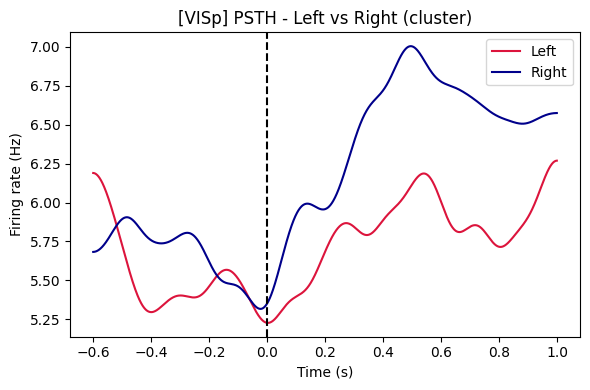

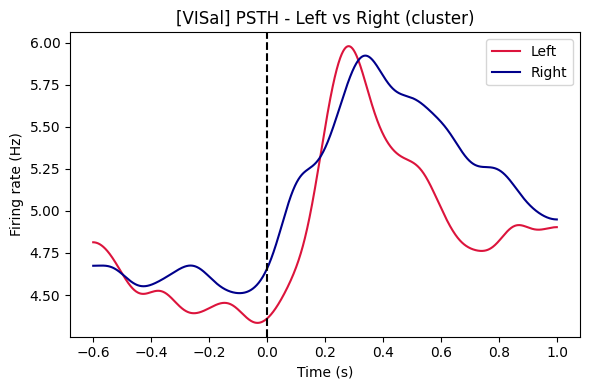

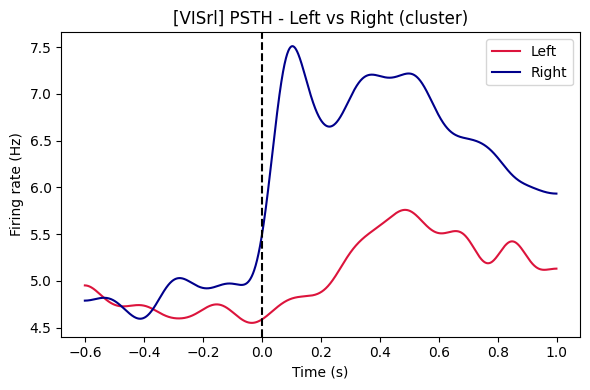

Done.


In [7]:
# -----------------------------------------------------------------------------
# 2. Trial / Spike data 로드 (SessionLoader, SpikeSortingLoader)
# -----------------------------------------------------------------------------
# Trial 데이터
sl = SessionLoader(eid=eid, one=one)
sl.load_trials()
events = sl.trials['stimOn_times'].values
left_idx, right_idx, correct_idx, incorrect_idx = get_trial_masks(sl.trials) # trial mask

brain_region_list = ['VISp', 'VISl', 'VISal', 'VISpm', 'VISrl']

for brain_region, cluster_label in [(region, 'cluster') for region in brain_region_list]:
    print(f"\nbrain_region : {brain_region}\n")
    spike_raster_all = []
    for i, (pid, probe_label) in enumerate(zip(pids, probe_labels)):
        print(f"🔍 [{probe_label}], pid[{i}]: {pid}")

        # Spike Sorting 데이터
        ssl = SpikeSortingLoader(one=one, pid=pid, atlas=AllenAtlas())
        spikes, clusters, channels = ssl.load_spike_sorting()
        clusters = ssl.merge_clusters(spikes, clusters, channels)
        clusters = pd.DataFrame(clusters)

        # -----------------------------------------------------------------------------
        # 3. 특정 영역(문자열 포함) Mask 정의 (모든 + good)
        # -----------------------------------------------------------------------------
        good_mask = (clusters['label'] == 1)

        if brain_region == 'VISp':
            region_mask = np.array(['VISp' in acr for acr in clusters['acronym']]) & ~np.array(['VISpm' in acr for acr in clusters['acronym']])
        else:
            region_mask = np.array([brain_region in acr for acr in clusters['acronym']])
        
        # selected_mask = region_mask & good_mask
        selected_mask = region_mask
        
        # -----------------------------------------------------------------------------
        # -----------------------------------------------------------------------------
        # 6. 두 가지 경우(모든 클러스터 / good 클러스터)에 대해 동일한 분석
        # -----------------------------------------------------------------------------
        
            
        selected_cluster_ids = np.where(selected_mask)[0] # 해당되는 클러스터 ID들.
        # print(f"\n🔍 Selected cluster IDs for {brain_region} ({cluster_label}): {selected_cluster_ids}")
        if cluster_label == "Single Cluster":
            selected_cluster_ids = [selected_cluster_ids[0]]

        n_clusters = len(selected_cluster_ids)
        print(f">> {n_clusters} {cluster_label} found.")
        if n_clusters == 0:
            continue
        else:
            spike_raster, times = compute_raster(spikes, selected_cluster_ids, events, pre_time=0.6, post_time=1, bin_size=0.001)
            
            for unit_raster in spike_raster:
                spike_raster_all.append(unit_raster)
                
    if len(spike_raster_all) == 0:
        print(f"{brain_region} : No valid spike raster found.")
        continue

    spike_raster_all = np.array(spike_raster_all)  # spike_raster_all.shape = (nUnits_total, nTrials, nBins)

    #plot_raster(spike_raster, times, events, brain_region, cluster_label, RESULT_DIR)
    #plot_psth_2x2(spike_raster, times, left_idx, right_idx, correct_idx, incorrect_idx, brain_region, cluster_label, RESULT_DIR)
    #plot_psth_contrast(spike_raster, times, sl.trials, left_idx, right_idx, brain_region, cluster_label, RESULT_DIR)
    plot_psth_left_vs_right(spike_raster_all, times, left_idx, right_idx, brain_region, cluster_label, RESULT_DIR)

plt.show(block=False) 
plt.close('all')
print("Done.")


brain_region : VISp

🔍 [probe01], pid[0]: 5544da75-8d34-47cb-9092-1f91e713e79c
>> 0 good_cluster found.
🔍 [probe00], pid[1]: 5e8ac11b-959a-49ab-a6a3-8a3397e1df0e
>> 0 good_cluster found.
VISp : No valid spike raster found.

brain_region : VISl

🔍 [probe01], pid[0]: 5544da75-8d34-47cb-9092-1f91e713e79c
>> 0 good_cluster found.
🔍 [probe00], pid[1]: 5e8ac11b-959a-49ab-a6a3-8a3397e1df0e
>> 0 good_cluster found.
VISl : No valid spike raster found.

brain_region : VISal

🔍 [probe01], pid[0]: 5544da75-8d34-47cb-9092-1f91e713e79c
>> 44 good_cluster found.
🔍 [probe00], pid[1]: 5e8ac11b-959a-49ab-a6a3-8a3397e1df0e
>> 0 good_cluster found.

brain_region : VISpm

🔍 [probe01], pid[0]: 5544da75-8d34-47cb-9092-1f91e713e79c
>> 0 good_cluster found.
🔍 [probe00], pid[1]: 5e8ac11b-959a-49ab-a6a3-8a3397e1df0e
>> 0 good_cluster found.
VISpm : No valid spike raster found.

brain_region : VISrl

🔍 [probe01], pid[0]: 5544da75-8d34-47cb-9092-1f91e713e79c
>> 1 good_cluster found.
🔍 [probe00], pid[1]: 5e8ac11b-

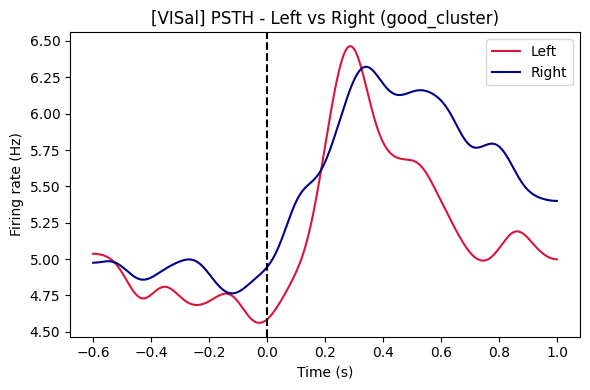

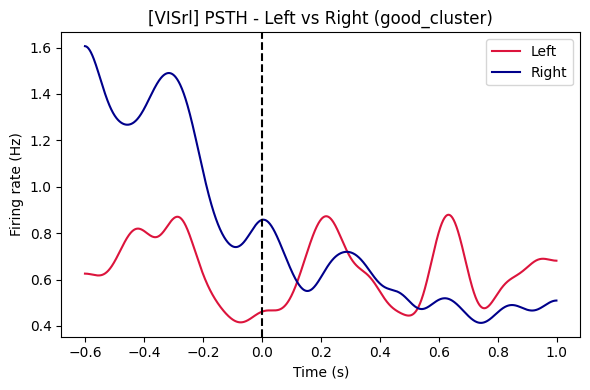

Done.


In [8]:
# -----------------------------------------------------------------------------
# 2. Trial / Spike data 로드 (SessionLoader, SpikeSortingLoader)
# -----------------------------------------------------------------------------
# Trial 데이터
sl = SessionLoader(eid=eid, one=one)
sl.load_trials()
events = sl.trials['stimOn_times'].values
left_idx, right_idx, correct_idx, incorrect_idx = get_trial_masks(sl.trials) # trial mask

brain_region_list = ['VISp', 'VISl', 'VISal', 'VISpm', 'VISrl']

for brain_region, cluster_label in [(region, 'good_cluster') for region in brain_region_list]:
    print(f"\nbrain_region : {brain_region}\n")
    spike_raster_all = []
    for i, (pid, probe_label) in enumerate(zip(pids, probe_labels)):
        print(f"🔍 [{probe_label}], pid[{i}]: {pid}")

        # Spike Sorting 데이터
        ssl = SpikeSortingLoader(one=one, pid=pid, atlas=AllenAtlas())
        spikes, clusters, channels = ssl.load_spike_sorting()
        clusters = ssl.merge_clusters(spikes, clusters, channels)
        clusters = pd.DataFrame(clusters)

        # -----------------------------------------------------------------------------
        # 3. 특정 영역(문자열 포함) Mask 정의 (모든 + good)
        # -----------------------------------------------------------------------------
        good_mask = (clusters['label'] == 1)

        if brain_region == 'VISp':
            region_mask = np.array(['VISp' in acr for acr in clusters['acronym']]) & ~np.array(['VISpm' in acr for acr in clusters['acronym']])
        else:
            region_mask = np.array([brain_region in acr for acr in clusters['acronym']])
        
        # selected_mask = region_mask & good_mask
        selected_mask = region_mask & good_mask
        
        # -----------------------------------------------------------------------------
        # -----------------------------------------------------------------------------
        # 6. 두 가지 경우(모든 클러스터 / good 클러스터)에 대해 동일한 분석
        # -----------------------------------------------------------------------------
        
            
        selected_cluster_ids = np.where(selected_mask)[0] # 해당되는 클러스터 ID들.
        # print(f"\n🔍 Selected cluster IDs for {brain_region} ({cluster_label}): {selected_cluster_ids}")
        if cluster_label == "Single Cluster":
            selected_cluster_ids = [selected_cluster_ids[0]]

        n_clusters = len(selected_cluster_ids)
        print(f">> {n_clusters} {cluster_label} found.")
        if n_clusters == 0:
            continue
        else:
            spike_raster, times = compute_raster(spikes, selected_cluster_ids, events, pre_time=0.6, post_time=1, bin_size=0.001)
            
            for unit_raster in spike_raster:
                spike_raster_all.append(unit_raster)
                
    if len(spike_raster_all) == 0:
        print(f"{brain_region} : No valid spike raster found.")
        continue

    spike_raster_all = np.array(spike_raster_all)  # spike_raster_all.shape = (nUnits_total, nTrials, nBins)

    #plot_raster(spike_raster, times, events, brain_region, cluster_label, RESULT_DIR)
    #plot_psth_2x2(spike_raster, times, left_idx, right_idx, correct_idx, incorrect_idx, brain_region, cluster_label, RESULT_DIR)
    #plot_psth_contrast(spike_raster, times, sl.trials, left_idx, right_idx, brain_region, cluster_label, RESULT_DIR)
    plot_psth_left_vs_right(spike_raster_all, times, left_idx, right_idx, brain_region, cluster_label, RESULT_DIR)

plt.show(block=False) 
plt.close('all')
print("Done.")